 libraries

In [43]:
import wfdb #waveform database 
# from wfdb import processing
import os
import pandas as pd
import glob as gb
import matplotlib.pyplot as plt
import numpy as np
# import pandas as pd
import tensorflow as tf
# from scipy import signal
from sklearn.model_selection import train_test_split #to split data
import pywt #pywavelet lib
from scipy.signal import wiener
# from sklearn import preprocessing
%matplotlib inline
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout , LSTM , Bidirectional , BatchNormalization
from keras.optimizers import Adam
from tensorflow.math import confusion_matrix
from sklearn.metrics import classification_report,roc_curve, auc
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import seaborn as sns

functions

1-Preprocessing

    1.1 for Feature Extraction

In [2]:
#to find paths for all records using my database , the files should have attributes
def find_paths (file_paths):
    file_paths = gb.glob(folder_path + '/*.atr')
    file_paths = [os.path.splitext(path)[0].replace("\\", "/") for path in file_paths]
    return file_paths

In [3]:
#for spliting all records into beats
def split_records(record_list):
    beats=[]
    annotation_symbols=[]
    # first it should navigte all paths(The last function ensured that all files had got)
    for record_Name in record_list :
        record=wfdb.rdrecord(record_Name)
        if record.sig_name[0]=='V4'or record.sig_name[1]=='V4':
            #first we need to fitch the ecg signals samples (we have 2 signals)
            ecg_signal=record.p_signal[:,record.sig_name.index('V4')]
            # Then we will filter the signals and normalize them
            ecg_signal=wavelet_denoising (ecg_signal)
            ecg_signal=wiener(ecg_signal)
            ecg_signal=normalize_ecg (ecg_signal)
            #Then we can fitch the annotations (Labels)
            annotation = wfdb.rdann(record_Name, 'atr', sampfrom=0, sampto=record.sig_len)
            # Get the indices of the QRS complexes (peaks)
            qrs_inds = annotation.sample[1:]
            # Define the duration (in samples) for each beat segment
            beat_duration = int(record.fs)  # Assuming a 250 ms duration for each beat
            for qrs_ind in qrs_inds:
                start = max(0, qrs_ind - beat_duration // 2)  # Start of the beat segment
                end = min(qrs_ind + beat_duration // 2, record.sig_len)  # End of the beat segment
                beat = ecg_signal[start:end]  # Extract the beat segment
                beat=beat.tolist()
                #if the beat length was less than 50 ms it will be a problem , so we can use the last sample to complete the beat
                #some samples will not affect on the signal because it represent a small amount
                if len(beat)<250:
                    a=beat[-1]
                    for i in range(250-len(beat)):
                        beat.append(a)
                beat=np.array(beat)
                beats.append(beat)
                beat=[]
            annotation_symbols.append((annotation.symbol[1:]))
        if record.sig_name[0]=='V5'or record.sig_name[1]=='V5':
            #first we need to fitch the ecg signals samples (we have 2 signals)
            ecg_signal=record.p_signal[:,record.sig_name.index('V5')]
            # Then we will filter the signals and normalize them
            ecg_signal=wavelet_denoising (ecg_signal)
            ecg_signal=wiener(ecg_signal)
            ecg_signal=normalize_ecg (ecg_signal)
            #Then we can fitch the annotations (Labels)
            annotation = wfdb.rdann(record_Name, 'atr', sampfrom=0, sampto=record.sig_len)
            # Get the indices of the QRS complexes (peaks)
            qrs_inds = annotation.sample[1:]
            # Define the duration (in samples) for each beat segment
            beat_duration = int(record.fs)  # Assuming a 250 ms duration for each beat
            for qrs_ind in qrs_inds:
                start = max(0, qrs_ind - beat_duration // 2)  # Start of the beat segment
                end = min(qrs_ind + beat_duration // 2, record.sig_len)  # End of the beat segment
                beat = ecg_signal[start:end]  # Extract the beat segment
                beat=beat.tolist()
                #if the beat length was less than 50 ms it will be a problem , so we can use the last sample to complete the beat
                #some samples will not affect on the signal because it represent a small amount
                if len(beat)<250:
                    a=beat[-1]
                    for i in range(250-len(beat)):
                        beat.append(a)
                beat=np.array(beat)
                beats.append(beat)
                beat=[]
            annotation_symbols.append((annotation.symbol[1:]))
    beats=np.array(beats)
    #Then we need to make a big array sort annotation not as a list for each record , but as a big array that include all labels
    annotation_symbols = [item for sublist in annotation_symbols for item in sublist]
    annotation_symbols,annotation_symbols_dic,symb_num = encoder(annotation_symbols)
    annotation_symbols=np.array(annotation_symbols)
    data=make_df(beats,annotation_symbols)
    
    return beats , annotation_symbols,annotation_symbols_dic,symb_num

In [4]:
# I need to collect data in CSV file to handle the inbalanced data
def make_df (beats , Labels):
    beat_data=pd.Series(beats.tolist(),name='beats')
    ann=pd.Series(Labels,name='annotations')
    data=pd.concat([beat_data,ann],axis=1)
    data=data.sample(frac=1).reset_index(drop=True)
    return data

    1.2 Preprocessing Signals

In [5]:
#for removing noise from data
def wavelet_denoising (ecg_signal):
    # Apply wavelet transform
    wavelet = 'db6'  # Choose the desired wavelet
    coeffs = pywt.wavedec(ecg_signal, wavelet) #decomposing signal 

    # Set a threshold for noise removal
    threshold = 0.5  # Adjust according to your signal characteristics

    # Apply thresholding to remove noise
    denoised_coeffs = [pywt.threshold(c, threshold) for c in coeffs]

    # Reconstruct the denoised signal
    denoised_signals = pywt.waverec(denoised_coeffs, wavelet)
    return denoised_signals

In [6]:
#for normalizing data
def normalize_ecg (ecg_signal):
    normalize_signal=(ecg_signal-np.mean(ecg_signal))/np.std(ecg_signal)
    return normalize_signal

In [7]:
#encoding the labels in training stage (the fitting statment code doesn't accept strings as a labels)
#this function can transform the string labels to integer labels
#according to number of labels
#this function is used in spliting records
def encoder (labels):
    my_set_labels=set(labels)
    my_set_numbers=set(range(len(my_set_labels)))
    my_dic = dict(zip(my_set_labels,my_set_numbers))
    converted_list = [my_dic.get(item, item) for item in labels]
    return converted_list , my_dic , len(set(converted_list))

In [8]:
#decoding the labels in testing stage
#after encoding , we can return the labels to strings using the dictionary of classifications
#this function return the original labels
def decoder (labels,dic):
    labels=[next(key for key, value in dic.items() if value == t ) for t in labels]
    return labels

    1.3 Data Augmentation

In [9]:
#To handle thunbalanced data , you need to make know the majority data (usually normal data)
def filter_data (data):
    # Assuming 'data' is your DataFrame
    # Find the majority value
    majority_value = data['annotations'].value_counts().idxmax()

    # Filter the DataFrame to exclude rows with the majority value
    abnormal_data = data[data['annotations'] != majority_value]
    normal_data=data[data['annotations'] == majority_value]
    
    return abnormal_data , normal_data

In [10]:
# Frequency Domain Transformations (Applying Gaussian Noise)
def frequency_transform(signal, noise_level=0.01):
    noise = np.random.normal(0, noise_level, len(signal))
    fft_signal = np.fft.fft(signal)
    fft_signal += noise
    return np.fft.ifft(fft_signal).real

In [11]:
# Data augmentation for minority classes
def increase_data (abnormal_data,normal_data):
    # Data augmentation for minority class
    augmented_data1 = []
    augmented_data2 = []
    for index, row in abnormal_data.iterrows():
        signal = row['beats']  # Assuming 'Data' column contains the signal
        # Apply augmentation techniques
        augmented_signal1 = frequency_transform(signal, noise_level=0.01)
#         augmented_signal2 = envelope_interpolation(signal, interpolation_factor=2)
        augmented_data1.append(augmented_signal1)
#         augmented_data2.append(augmented_signal2)
    # Create DataFrame from augmented data
    augmented_df1 = pd.DataFrame({'beats': augmented_data1, 'annotations': abnormal_data['annotations']})
#     augmented_df2 = pd.DataFrame({'beats': augmented_data2, 'annotations': abnormal_data['annotations']})
    abnor_data= pd.concat([abnormal_data, augmented_df1])
    abnor_data= abnor_data.sample(frac=1.0)
    normal_data = normal_data.sample(n=len(abnor_data))
    final_data=pd.concat([abnor_data,normal_data])
    final_data=final_data.sample(frac=1.0,random_state=42)
    return final_data

    1.4 Splitting data

In [12]:
#for spliting thim into train,test&valid
def spliting_data (data):
    beats = np.array(data.iloc[:,0])
    annotation_symbols=np.array(data.iloc[:,1])
    beats = np.array([np.array(sublist) for sublist in beats])
    X_train, X_test, Y_train, Y_test = train_test_split(beats,annotation_symbols, test_size=0.3, random_state=42)
    X_test, X_valid, Y_test, Y_valid = train_test_split(X_test,Y_test, test_size=0.5, random_state=42)
    return X_train ,X_test , X_valid , Y_train , Y_test , Y_valid

2- Models

    2.1 RNN Model

In [69]:
# First model i used was RNN with 3 simple RNN Layers
def RNN_model (X_train,Y_train , X_valid , Y_valid , no_symbols,epochs):
     
    RNN_model = Sequential([
            SimpleRNN(units=128, input_shape=(X_train.shape[1], 1), activation='relu', return_sequences=True),  
            Dropout(0.2),
            SimpleRNN(units=128, activation='relu', return_sequences=True),
            Dropout(0.2),
            SimpleRNN(units=128, activation='relu'),  
            Dropout(0.2),
            Dense(no_symbols, activation='softmax')  # Assuming no_symbols is the number of classes
        ])


    # Compile the model
    RNN_model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=Adam(learning_rate=1e-3),
                  metrics=['accuracy'])
    #ModelSummary
    RNN_summary=RNN_model.summary()
    # Train the model
    RNN_hist_model = RNN_model.fit(X_train, Y_train,
                                  epochs=epochs , validation_data=(X_valid, Y_valid))
    return RNN_summary,RNN_model,RNN_hist_model

    2.2 LSTM

In [34]:
# Second model i used was LSTM with 3 Bidirectional LSTM Layers
def LSTM_model (X_train,Y_train , X_valid , Y_valid , no_symbols,epochs):

    LSTM_model = Sequential([
    (Bidirectional(LSTM(units=128,return_sequences=True),input_shape=(X_train.shape[1], 1))),  # LSTM layer with 64 units
    (Dropout(0.2)),
    (Bidirectional(LSTM(units=64,return_sequences=True))),  # LSTM layer with 64 units
    Dropout(0.2),
    Bidirectional(LSTM(units=32)),  # Third LSTM layer with 64 units
    Dense(units=no_symbols , activation='softmax')   # Output layer with 5 units (one for each class)
    ])

    # Compile the model
    LSTM_model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    LSTM_summary=LSTM_model.summary()
    # Train the model
    LSTM_hist_model = LSTM_model.fit(X_train, Y_train,
                                  epochs=epochs, batch_size=32,
                                  validation_data=(X_valid, Y_valid))
    return LSTM_summary, LSTM_model,LSTM_hist_model

3- Model Evaluation

    3.1 Evaluation The Performance

In [15]:
def evaluate_model(model,X_test,Y_test):
    test_loss, test_accuracy = model.evaluate(X_test, Y_test)
    print("Test Accuracy:", test_accuracy*100)
    print("Test Loss:", test_loss)

    3.2 Predicting The Values

In [125]:
#Predict The values of each sample
def predict (X_test,model):
    prop=model.predict(X_test)
    y_pred=np.argmax(prop,axis=1)
    return y_pred,prop

4- Statistical Representation 

    4.1 Loss Graph

In [17]:
def Loss_comp_graph (h_Model1,h_Model2,model1_name,model2_name):
    plt.figure(figsize=(12, 5))
    plt.plot(h_Model1.history['loss'], label=f'{model1_name} Train')
    plt.plot(h_Model1.history['val_loss'], label=f'{model1_name} Validation')
    plt.plot(h_Model2.history['loss'], label=f'{model2_name} Train')
    plt.plot(h_Model2.history['val_loss'], label=f'{model2_name} Validation')
    plt.title('Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    4.2 Accuracy Graph

In [18]:
def Accuracy_comp_graph (h_Model1,h_Model2,model1_name,model2_name):
    plt.figure(figsize=(12, 5))
    plt.plot(h_Model1.history['accuracy'], label=f'{model1_name} Train')
    plt.plot(h_Model1.history['val_accuracy'], label=f'{model1_name} Validation')
    plt.plot(h_Model2.history['accuracy'], label=f'{model2_name} Train')
    plt.plot(h_Model2.history['val_accuracy'], label=f'{model2_name} Validation')
    plt.title('Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    4.3 Comparing between True and Predicted Values

In [118]:
def conf_mat (Y_test , Y_pred,dic={}):
    Y_pred_encoded=[]
    if (type(Y_pred[0])==int):
        for i in Y_pred :
            Y_pred_encoded.append(dic[i])
        Y_pred=Y_pred_encoded
    conf_matrix = confusion_matrix(Y_test , Y_pred)
    if isinstance(conf_matrix, tf.Tensor):
        conf_matrix = conf_matrix.numpy()
        # Initialize lists to store the metrics
    tp_list = []
    tn_list = []
    fp_list = []
    fn_list = []
    sensitivity_list = []
    specificity_list = []
    num_classes = conf_matrix.shape[0]
    for i in range(num_classes):
        tp = conf_matrix[i, i]
        fp = conf_matrix[:, i].sum() - tp
        fn = conf_matrix[i, :].sum() - tp
        tn = conf_matrix.sum() - (tp + fp + fn)
        
        tp_list.append(tp)
        tn_list.append(tn)
        fp_list.append(fp)
        fn_list.append(fn)
        
        print(f'Class {i} - TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}')
                # Calculate sensitivity and specificity
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        sensitivity_list.append(sensitivity)
        specificity_list.append(specificity)
        
        print(f'Class {i} - Sensitivity: {sensitivity:.2f}, Specificity: {specificity:.2f}')
    plt.figure(figsize=(15,7))
    sns.heatmap(conf_matrix,annot=True , fmt='d',cmap='Blues')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    if not Y_pred_encoded:
        return Y_pred , tp_list, tn_list, fp_list, fn_list
    else :
        return Y_pred_encoded , tp_list, tn_list, fp_list, fn_list


In [136]:
def ROC_graph (y_true , y_pred_prob,n_classes):
    # Calculate the ROC curve for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve((y_true == i).astype(int), y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

Reading Files & Appling functions

In [20]:
folder_path = 'D:/3rd Biomedical/2nd semister/MedicalSignals/Project/DataBase2/european-st-t-database-1.0.0'

In [21]:
file_paths=find_paths(folder_path)

In [22]:
beats,annotations,annotations_dic,symb_num=split_records(file_paths)

D:\anaconda\Lib\site-packages\scipy\signal\_signaltools.py:1657: RuntimeWarning: divide by zero encountered in divide
  res *= (1 - noise / lVar)
D:\anaconda\Lib\site-packages\scipy\signal\_signaltools.py:1657: RuntimeWarning: divide by zero encountered in divide
  res *= (1 - noise / lVar)
D:\anaconda\Lib\site-packages\scipy\signal\_signaltools.py:1657: RuntimeWarning: divide by zero encountered in divide
  res *= (1 - noise / lVar)
D:\anaconda\Lib\site-packages\scipy\signal\_signaltools.py:1657: RuntimeWarning: divide by zero encountered in divide
  res *= (1 - noise / lVar)
D:\anaconda\Lib\site-packages\scipy\signal\_signaltools.py:1657: RuntimeWarning: divide by zero encountered in divide
  res *= (1 - noise / lVar)


In [23]:
print(f'{beats}\n{annotations}\n{annotations_dic}\n{symb_num}')

[[-0.16181803 -0.13121779 -0.12937634 ... -0.60407612 -0.60407612
  -0.60407612]
 [-0.38789179 -0.3507071  -0.31035114 ... -0.34881773 -0.35498789
  -0.36043523]
 [-0.24619374 -0.25044318 -0.25581524 ... -0.27426062 -0.25535038
  -0.23455599]
 ...
 [-1.25290155 -1.25984425 -1.26637201 ... -0.15859017 -0.15518045
  -0.15315813]
 [-0.16363897 -0.15859017 -0.15518045 ... -0.32669922 -0.29987244
  -0.2725813 ]
 [-0.47300842 -0.46045669 -0.44414274 ... -0.71914126 -0.719469
  -0.71944481]]
[11 11 11 ... 11 11 11]
{'F': 0, '"': 1, 'V': 2, 's': 3, 'Q': 4, 'n': 5, '|': 6, '+': 7, '~': 8, 'S': 9, 'T': 10, 'N': 11, 'a': 12}
13


In [24]:
data=make_df(beats,annotations)

In [25]:
data.head()

,beats,annotations
0,"[0.3928484092330741, 0.40405746563761036, 0.41...",11
1,"[-3.4780838932290714, -3.4155530915936465, -3....",11
2,"[-0.15938030623192323, -0.1272547607410516, -0...",11
3,"[0.9905106905890847, 1.0570564203996453, 1.120...",11
4,"[-0.025811347221803567, -0.01495029221747915, ...",11


In [26]:
Abnormal,Normal=filter_data(data)
print(f'{Abnormal.head()}\n{Normal.head()}')

                                                 beats  annotations
101  [0.27133051781935236, 0.2994565887142238, 0.32...           10
117  [0.7604359099130164, 0.7316426673555193, 0.672...           10
123  [-0.07155903270735199, -0.002613439221822575, ...            2
164  [0.7157735950920855, 0.6346594792567858, 0.554...            2
186  [-0.18640327207481663, -0.14865936306574243, -...            8
                                               beats  annotations
0  [0.3928484092330741, 0.40405746563761036, 0.41...           11
1  [-3.4780838932290714, -3.4155530915936465, -3....           11
2  [-0.15938030623192323, -0.1272547607410516, -0...           11
3  [0.9905106905890847, 1.0570564203996453, 1.120...           11
4  [-0.025811347221803567, -0.01495029221747915, ...           11


In [27]:
Final_data=increase_data(Abnormal,Normal)

In [28]:
Final_data.head()

,beats,annotations
472265,"[-0.46750569602649344, -0.4581057985801631, -0...",11
332423,"[-3.5093956539541513, -3.502532059934284, -3.4...",8
246748,"[-0.05868231437385519, -0.08822703131064243, -...",11
146971,"[0.26224667067808394, 0.27831215109168345, 0.2...",8
159331,"[0.5601284891515736, 0.5553455983816518, 0.550...",11


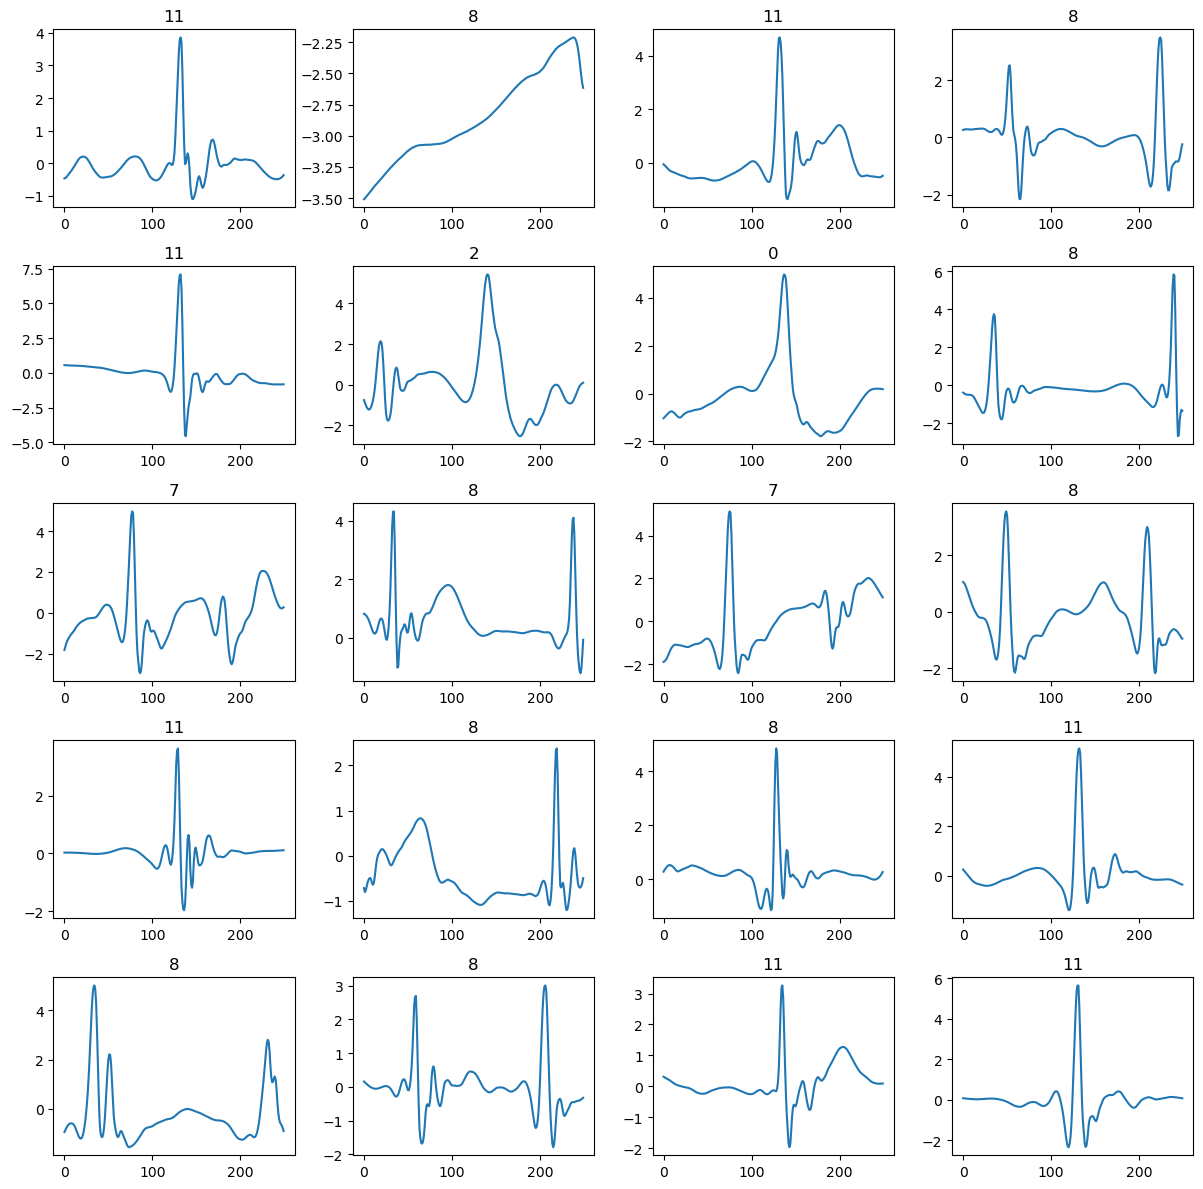

In [29]:
plt.figure(figsize=(12, 12))
for i in range(20):
    plt.subplot(5, 4, i + 1)
    plt.plot(Final_data.iloc[i,0])
    plt.title(Final_data.iloc[i,1])
plt.tight_layout()
plt.show()

spliting data

In [30]:
X_train ,X_test , X_valid , Y_train , Y_test , Y_valid = spliting_data(Final_data)

In [31]:
X_train
Y_train

array([ 7, 11,  8, ...,  9, 11, 11])

Training stage

In [39]:
LSTM_summary,LSTM_model , LSTM_hist_model=LSTM_model (X_train,Y_train , X_valid , Y_valid , symb_num ,epochs=30)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirecti  (None, 250, 256)          133120    
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 250, 256)          0         
                                                                 
 bidirectional_7 (Bidirecti  (None, 250, 128)          164352    
 onal)                                                           
                                                                 
 dropout_5 (Dropout)         (None, 250, 128)          0         
                                                                 
 bidirectional_8 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                      

In [70]:
RNN_summary,RNN_model , RNN_hist_model=RNN_model (X_train,Y_train , X_valid , Y_valid , symb_num,epochs=10)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_42 (SimpleRNN)   (None, 250, 128)          16640     
                                                                 
 dropout_48 (Dropout)        (None, 250, 128)          0         
                                                                 
 simple_rnn_43 (SimpleRNN)   (None, 250, 128)          32896     
                                                                 
 dropout_49 (Dropout)        (None, 250, 128)          0         
                                                                 
 simple_rnn_44 (SimpleRNN)   (None, 128)               32896     
                                                                 
 dropout_50 (Dropout)        (None, 128)               0         
                                                                 
 dense_17 (Dense)            (None, 13)              

results representing

In [71]:
# Evaluate the model (RNN)
evaluate_model(RNN_model,X_test,Y_test)

330/330 [==============================] - 32s 97ms/step - loss: 1.0098 - accuracy: 0.7033
Test Accuracy: 70.32747864723206
Test Loss: 1.0098332166671753


In [72]:
# Evaluate the model (LSTM)
evaluate_model(LSTM_model,X_test,Y_test)

330/330 [==============================] - 143s 434ms/step - loss: 0.3543 - accuracy: 0.8888
Test Accuracy: 88.88466954231262
Test Loss: 0.3542521595954895


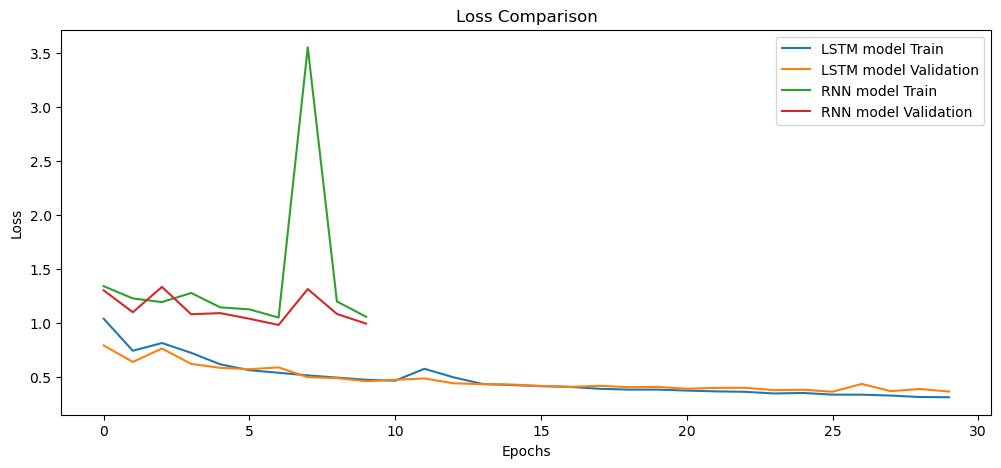

In [73]:
Loss_comp_graph(LSTM_hist_model,RNN_hist_model,'LSTM model','RNN model')

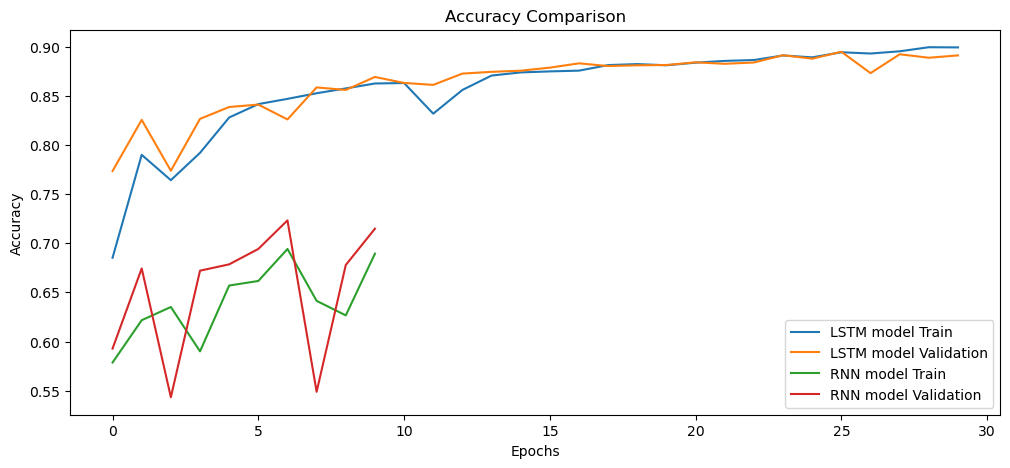

In [74]:
Accuracy_comp_graph(LSTM_hist_model,RNN_hist_model,'LSTM model','RNN model')

In [126]:
y_pred_RNN,prop_RNN=predict(X_test=X_test,model=RNN_model)

330/330 [==============================] - 33s 100ms/step


In [127]:
y_pred_RNN_decoder=decoder(labels=y_pred_RNN,dic=annotations_dic)

In [128]:
y_pred_LSTM,prop_LSTM=predict(X_test=X_test,model=LSTM_model)

330/330 [==============================] - 155s 470ms/step


In [129]:
y_pred_LSTM_decoder=decoder(labels=y_pred_LSTM,dic=annotations_dic)

In [80]:
Y_test_decoder=decoder(labels=Y_test,dic=annotations_dic)
Y_test_decoder

['N',
 'T',
 '~',
 '~',
 'N',
 'S',
 '~',
 'T',
 'N',
 's',
 'N',
 'N',
 'N',
 'N',
 'N',
 's',
 'N',
 '+',
 'F',
 '~',
 '~',
 'N',
 'V',
 'V',
 'N',
 'N',
 'N',
 '~',
 'F',
 '~',
 'N',
 's',
 'N',
 '~',
 'N',
 'N',
 'N',
 '~',
 'N',
 'N',
 '~',
 'V',
 'N',
 'N',
 'N',
 'V',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'V',
 'N',
 'N',
 'N',
 'N',
 'N',
 'V',
 'N',
 'N',
 'N',
 'N',
 '~',
 's',
 'N',
 '~',
 'N',
 'S',
 'N',
 'N',
 'N',
 'N',
 'V',
 'N',
 '~',
 'T',
 '~',
 '+',
 'V',
 'T',
 'N',
 'N',
 'N',
 '~',
 '~',
 's',
 '+',
 '~',
 'N',
 'N',
 'N',
 '~',
 'T',
 'N',
 'N',
 '"',
 'N',
 'N',
 'V',
 'N',
 'N',
 'N',
 '~',
 'S',
 'V',
 'N',
 'N',
 'S',
 'N',
 'N',
 'F',
 'S',
 'N',
 '~',
 'N',
 'N',
 '~',
 'N',
 '~',
 'N',
 '~',
 '~',
 'N',
 'S',
 'T',
 'N',
 's',
 'N',
 '~',
 'N',
 '+',
 'V',
 'N',
 '~',
 'N',
 '~',
 'V',
 '+',
 '~',
 'N',
 '~',
 '~',
 '~',
 's',
 'N',
 '~',
 '~',
 'N',
 '~',
 'N',
 '~',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N',
 'N'

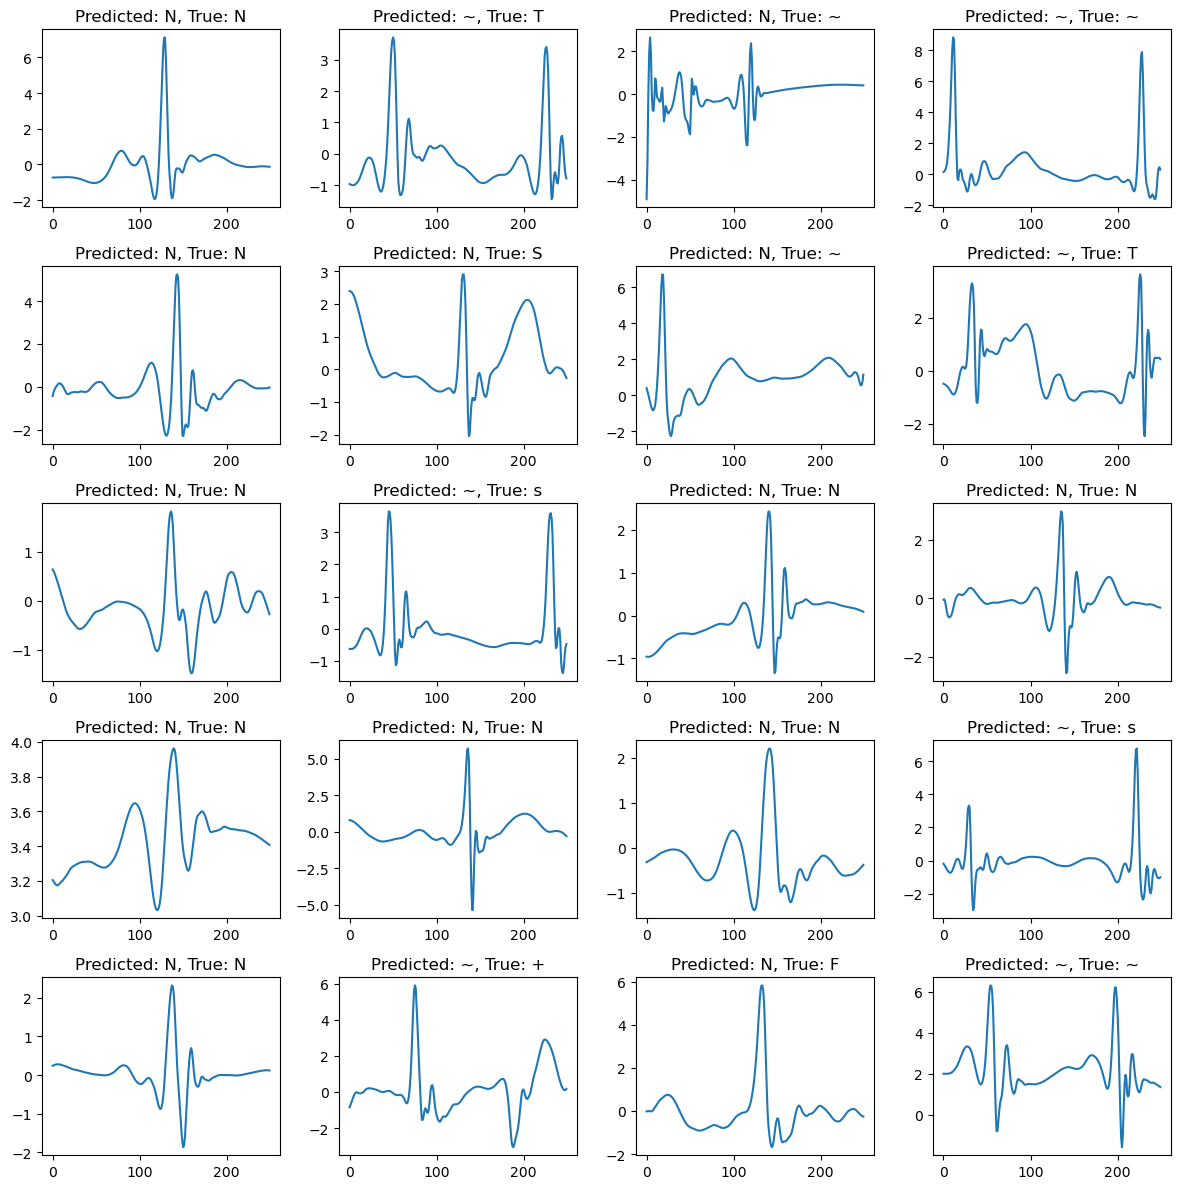

In [130]:
plt.figure(figsize=(12, 12))
for i in range(20):
    plt.subplot(5, 4, i + 1)
    plt.plot(X_test[i])
    plt.title(f"Predicted: {y_pred_RNN_decoder[i]}, True: {Y_test_decoder[i]}")
plt.tight_layout()
plt.show()

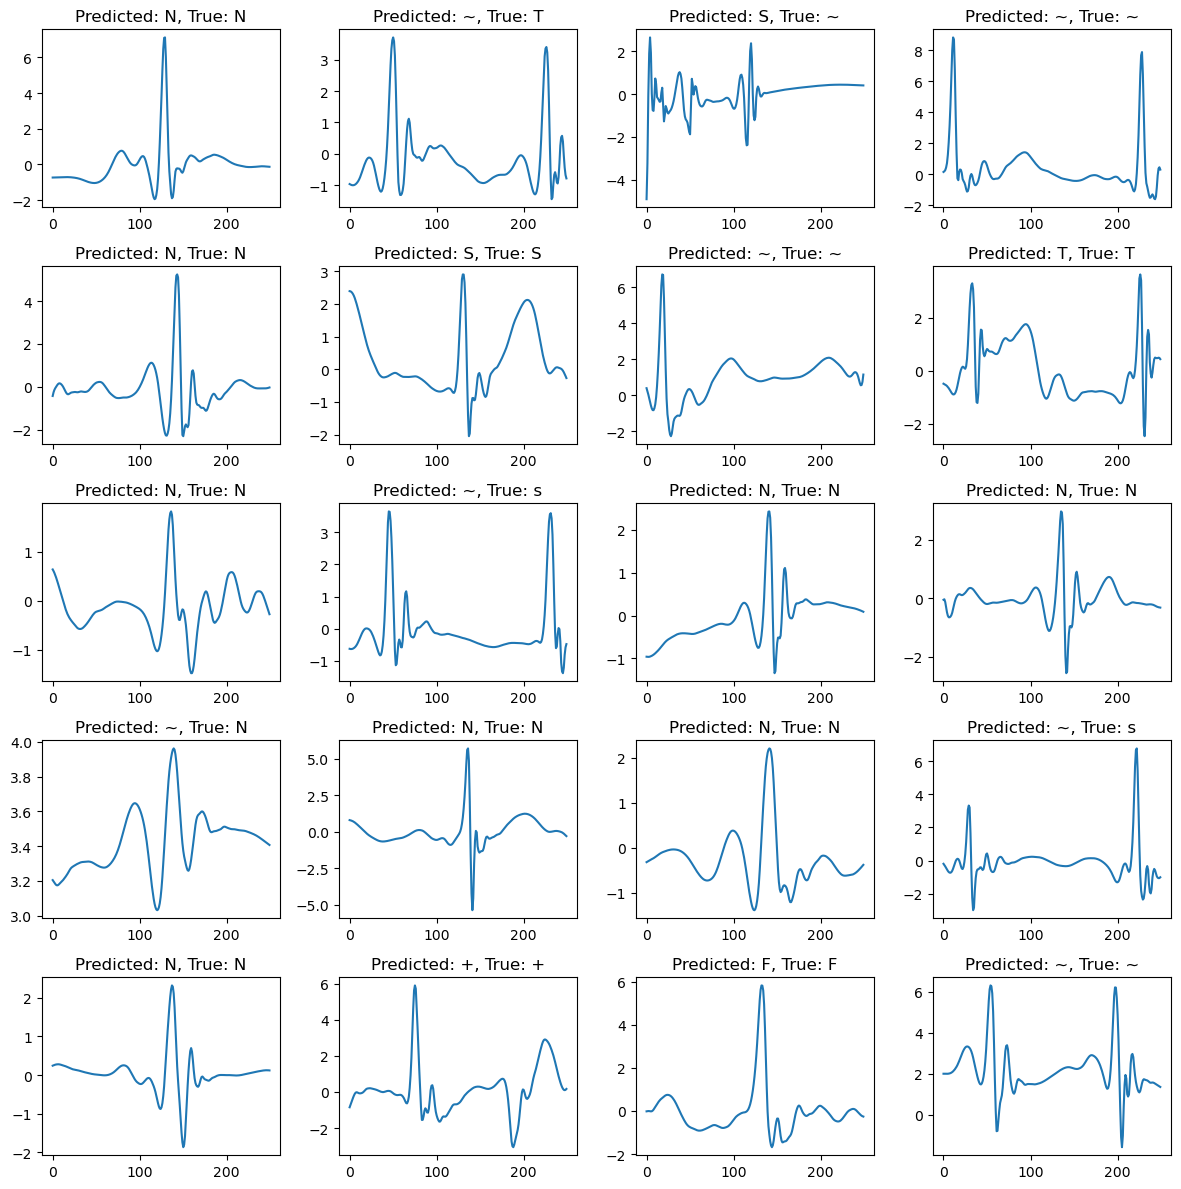

In [131]:
plt.figure(figsize=(12, 12))
for i in range(20):
    plt.subplot(5, 4, i + 1)
    plt.plot(X_test[i])
    plt.title(f"Predicted: {y_pred_LSTM_decoder[i]}, True: {Y_test_decoder[i]}")
plt.tight_layout()
plt.show()

Class 0 - TP: 0, TN: 10430, FP: 0, FN: 105
Class 0 - Sensitivity: 0.00, Specificity: 1.00
Class 1 - TP: 0, TN: 10506, FP: 0, FN: 29
Class 1 - Sensitivity: 0.00, Specificity: 1.00
Class 2 - TP: 546, TN: 8761, FP: 395, FN: 833
Class 2 - Sensitivity: 0.40, Specificity: 0.96
Class 3 - TP: 0, TN: 10248, FP: 0, FN: 287
Class 3 - Sensitivity: 0.00, Specificity: 1.00
Class 4 - TP: 0, TN: 10532, FP: 0, FN: 3
Class 4 - Sensitivity: 0.00, Specificity: 1.00
Class 5 - TP: 0, TN: 10533, FP: 0, FN: 2
Class 5 - Sensitivity: 0.00, Specificity: 1.00
Class 6 - TP: 0, TN: 10508, FP: 0, FN: 27
Class 6 - Sensitivity: 0.00, Specificity: 1.00
Class 7 - TP: 0, TN: 10315, FP: 0, FN: 220
Class 7 - Sensitivity: 0.00, Specificity: 1.00
Class 8 - TP: 1969, TN: 7058, FP: 881, FN: 627
Class 8 - Sensitivity: 0.76, Specificity: 0.89
Class 9 - TP: 0, TN: 10191, FP: 0, FN: 344
Class 9 - Sensitivity: 0.00, Specificity: 1.00
Class 10 - TP: 0, TN: 10183, FP: 0, FN: 352
Class 10 - Sensitivity: 0.00, Specificity: 1.00
Class 1

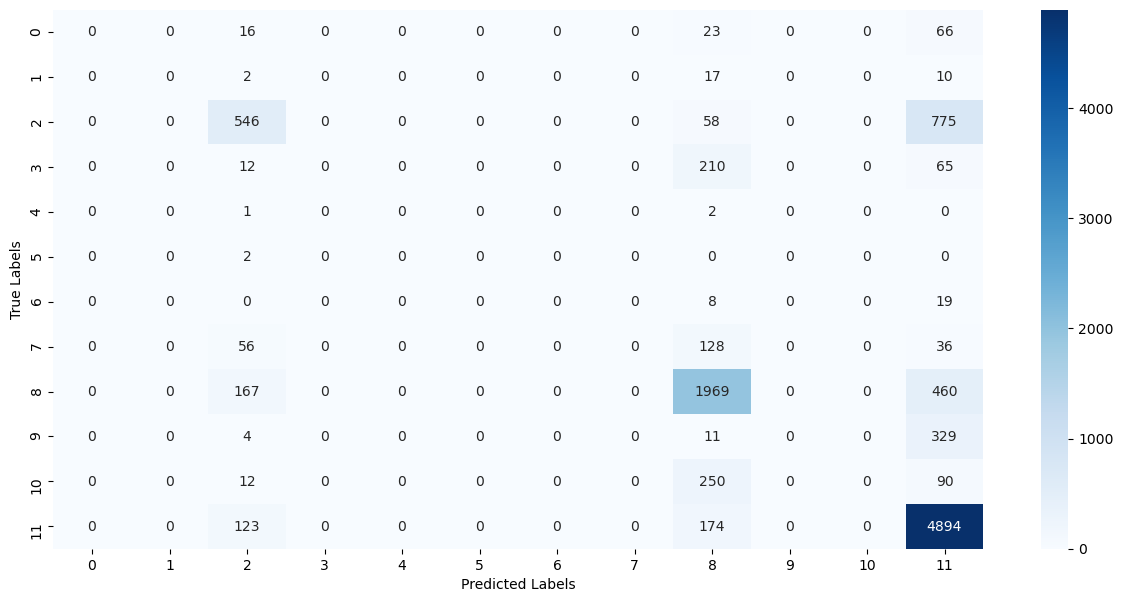

In [132]:
Y_pred_RNN_encoded , tn_RNN, fp_RNN, fn_RNN, tp_RNN= conf_mat(Y_test , y_pred_RNN,annotations_dic)

Class 0 - TP: 59, TN: 10417, FP: 13, FN: 46
Class 0 - Sensitivity: 0.56, Specificity: 1.00
Class 1 - TP: 1, TN: 10502, FP: 4, FN: 28
Class 1 - Sensitivity: 0.03, Specificity: 1.00
Class 2 - TP: 1361, TN: 9104, FP: 52, FN: 18
Class 2 - Sensitivity: 0.99, Specificity: 0.99
Class 3 - TP: 41, TN: 10158, FP: 90, FN: 246
Class 3 - Sensitivity: 0.14, Specificity: 0.99
Class 4 - TP: 1, TN: 10532, FP: 0, FN: 2
Class 4 - Sensitivity: 0.33, Specificity: 1.00
Class 5 - TP: 1, TN: 10533, FP: 0, FN: 1
Class 5 - Sensitivity: 0.50, Specificity: 1.00
Class 6 - TP: 4, TN: 10503, FP: 5, FN: 23
Class 6 - Sensitivity: 0.15, Specificity: 1.00
Class 7 - TP: 184, TN: 10291, FP: 24, FN: 36
Class 7 - Sensitivity: 0.84, Specificity: 1.00
Class 8 - TP: 2397, TN: 7403, FP: 536, FN: 199
Class 8 - Sensitivity: 0.92, Specificity: 0.93
Class 9 - TP: 228, TN: 10076, FP: 115, FN: 116
Class 9 - Sensitivity: 0.66, Specificity: 0.99
Class 10 - TP: 59, TN: 10126, FP: 57, FN: 293
Class 10 - Sensitivity: 0.17, Specificity: 0.

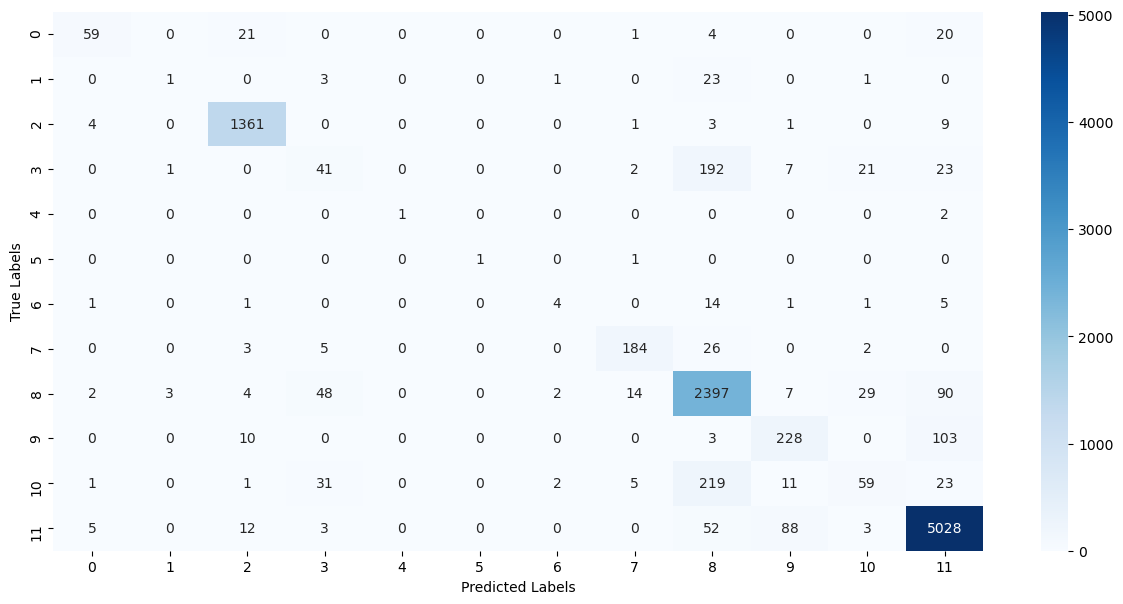

In [133]:
Y_pred_LSTM_encoded, tn_LSTM, fp_LSTM, fn_LSTM, tp_LSTM = conf_mat(Y_test , y_pred_LSTM,annotations_dic)

In [134]:
print(classification_report(Y_test_decoder,y_pred_RNN_decoder))

              precision    recall  f1-score   support

           "       0.00      0.00      0.00        29
           +       0.00      0.00      0.00       220
           F       0.00      0.00      0.00       105
           N       0.73      0.94      0.82      5191
           Q       0.00      0.00      0.00         3
           S       0.00      0.00      0.00       344
           T       0.00      0.00      0.00       352
           V       0.58      0.40      0.47      1379
           n       0.00      0.00      0.00         2
           s       0.00      0.00      0.00       287
           |       0.00      0.00      0.00        27
           ~       0.69      0.76      0.72      2596

    accuracy                           0.70     10535
   macro avg       0.17      0.17      0.17     10535
weighted avg       0.60      0.70      0.64     10535



D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [135]:
print(classification_report(Y_test_decoder,y_pred_LSTM_decoder))

              precision    recall  f1-score   support

           "       0.20      0.03      0.06        29
           +       0.88      0.84      0.86       220
           F       0.82      0.56      0.67       105
           N       0.95      0.97      0.96      5191
           Q       1.00      0.33      0.50         3
           S       0.66      0.66      0.66       344
           T       0.51      0.17      0.25       352
           V       0.96      0.99      0.97      1379
           n       1.00      0.50      0.67         2
           s       0.31      0.14      0.20       287
           |       0.44      0.15      0.22        27
           ~       0.82      0.92      0.87      2596

    accuracy                           0.89     10535
   macro avg       0.71      0.52      0.57     10535
weighted avg       0.87      0.89      0.87     10535



D:\anaconda\Lib\site-packages\sklearn\metrics\_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


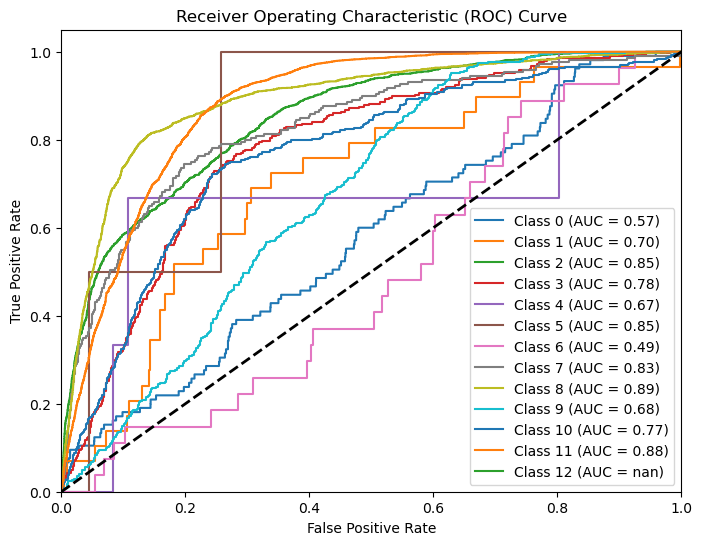

In [137]:
ROC_graph(Y_test,prop_RNN,symb_num)

D:\anaconda\Lib\site-packages\sklearn\metrics\_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


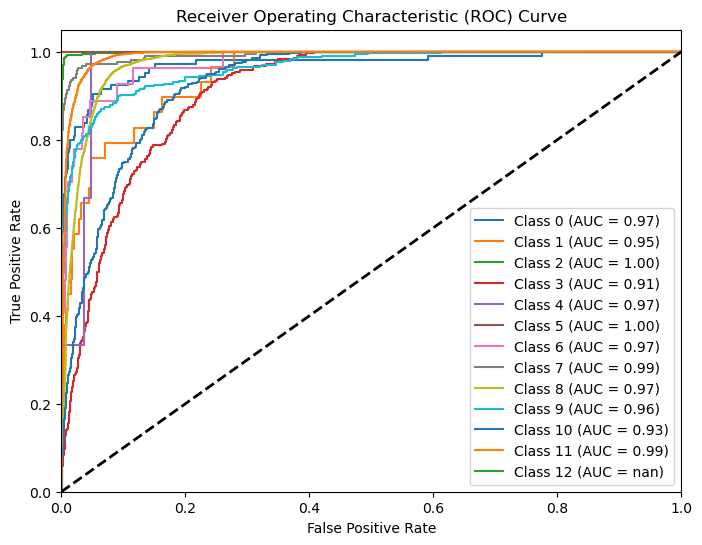

In [138]:
ROC_graph(Y_test,prop_LSTM,symb_num)

In [139]:
LSTM_model.save('D:/3rd Biomedical/2nd semister/LSTM_model.h5')

C:\Users\HP7\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [140]:
RNN_model.save('D:/3rd Biomedical/2nd semister/RNN_model.h5')

In [ ]:
dec_annotations = decoder(annotations,annotations_dic)
dec_annotations

In [ ]:
make_df(beats,dec_annotations).to_csv('D:/3rd Biomedical/2nd semister/data.csv', index=False)